In [2]:
from geographical_spatial_strength_extensions import *
import matplotlib.animation as animation
import math

In [2]:
plt.switch_backend('Qt4Agg')
plt.get_backend()

ImportError: Matplotlib qt-based backends require an external PyQt4, PyQt5,
or PySide package to be installed, but it was not found.

In [7]:
theta = math.pi * 2 / (3 ** 2)

In [10]:
math.sin(theta)

0.6427876096865393

In [56]:
def generate_rgg(n, r, size=1, pbc=False):
    G = SimpleSpatialGraph(size=[size, size])
    for _ in range(n):
        G.add_node()
        
    distances = pbc_distances(G, pbc=pbc)
    
    for i in range(G.node_count):
        for j in range(i+1, G.node_count):
            if(distances[i][j] < r*size):
                G.add_edge(i, j)
                G[i][j]['distance'] = distances[i][j]
                
    return G

def generate_neural_rgg(n, r, size=1, pbc=False, background=0.1, decay=0.5, threshold=1.0):
    '''
    generate a simple spatial rgg with conditions for neural simulation
    params:
        background: will be added randomly at uniform at +- this val to each node
        decay: will be multiplied to each nodes potential as signal decay
        threshold: firing threshold for nodes (may change this later to be picked from a distr)
    '''
    G = SimpleSpatialGraph(size=[size, size])
    G.background = background
    G.decay = decay
    G.threshold = threshold
    for _ in range(n):
        G.add_node(potential=0)
        
    distances = pbc_distances(G, pbc=pbc)
    
    for i in range(G.node_count):
        for j in range(i+1, G.node_count):
            if(distances[i][j] < r*size):
                G.add_edge(i, j, weight=np.random.uniform())
                G[i][j]['distance'] = distances[i][j]
                
    return G
    

Realize that different granularity inherently will produce different results as it decreases variance in a multiplicative fashion. There are some processes that simply behave differently with different step sizes (think optimization) so it's best to keep a consistent granularity throughout experiments.

For some reason multiplying by a factor of e for every 0.1 granularity balances out the long term distributions of the background? Maybe look into this later find a proof for why it happens

In [4]:
def continue_simulation(g, steps, granularity=1):
    #granularity scales every process. granularity -> 0 is asynchronous
    step_factor = 1 / granularity
    granular_decay_rate = 1/(1 - math.e ** (math.log(g.decay) * granularity)) * g.decay
    #note we shift the uniform distribution so multiply by 2 to stretch out to [-1, 1]
    granular_background_multiplier = math.e ** (-1 * math.log10(granularity)) * granularity * g.background * 2
    
    for i in range(steps):
        #run simulation step here
        #collect potentials
        potentials = []
        for n in range(g.node_count):
            potentials.append(g.nodes[n]['potential'])
        #decay
        for n in range(g.node_count):
            g.nodes[n]['potential'] = g.nodes[n]['potential'] * granular_decay_rate
        #add background
        for n in range(g.node_count):
            g.nodes[n]['potential'] += (np.random.uniform() - 0.5) * granular_background_multiplier
        #fire signals
        for n in range(g.node_count):
            if(potentials[n] > g.threshold):
                fire_signal(g, n)
        
        
            

def fire_signal(g, node, reset_potential=True):
    '''
    fire a signal from the given node sending to every node it has an edge to
    if reset_potential, set the node potential back to 0
    '''
    for edge in g[node]:
         g.nodes[edge]['potential'] += g[node][edge]['weight']
    if(reset_potential):
        g.nodes[node]['potential'] = 0

In [36]:
math.e ** -math.log10(granularity)



7.3890560989306495

In [93]:
for i in g[0]:
    print(i)

10
11
14
15
17
18
20
24
30
36
38
41
43
44
47


In [95]:
g.nodes[10]

{'coordinate': [0.504792850491236, 0.6553161161369173],
 'potential': 0.39242695860688315}

In [88]:
g.nodes[5]

{'coordinate': [0.09295674183755698, 0.49548738811668225], 'potential': 0}

In [57]:
g = generate_neural_rgg(50, 0.3)

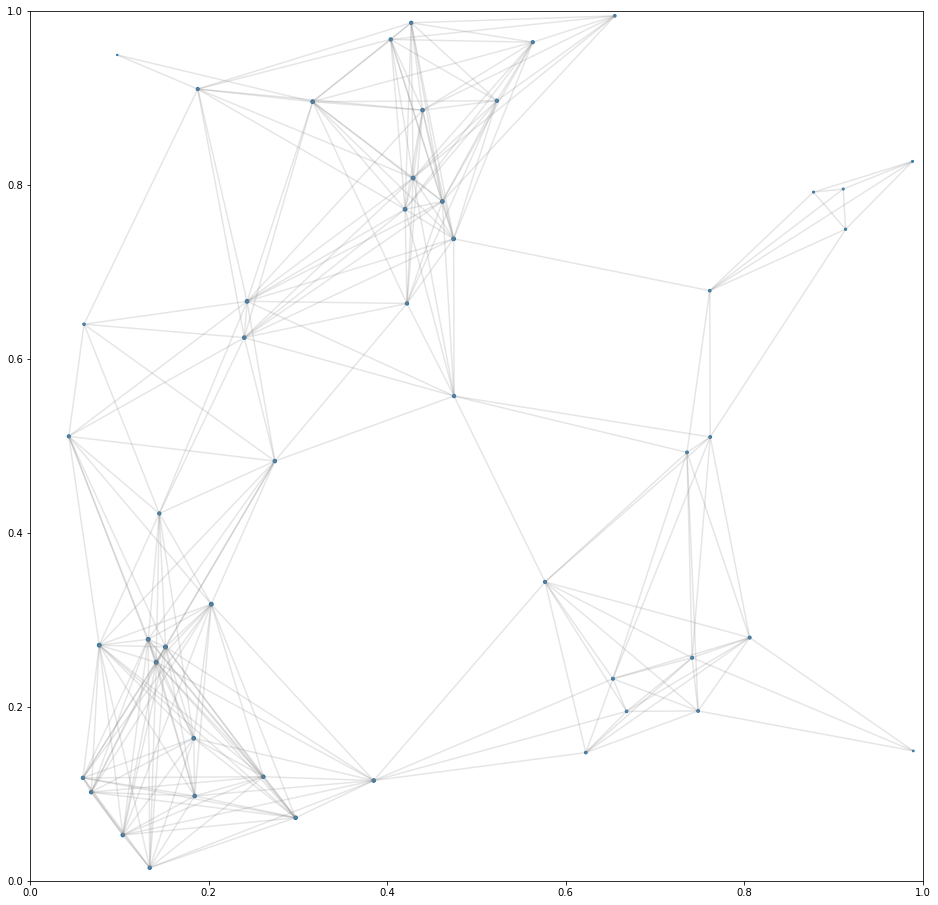

In [58]:
graph_spatial_network_plot_valued(g, graph_edges=True, pbc=False)

In [85]:
##ANIMATION

def graph_spatial_network_plot_valued(G, values=False, graph_edges=False, highlight_edges=False, color_points=False, color_bar=False, bounds=False, pbc=True):
    '''
    Create a plot showing what a 2D spatial graph looks like, coloring by passed values and sized by degree
    params:
        G: passed in SimpleSpatialGraph
        values: values according to the labels of the nodes
        graph_edges: graph edges as well (this function takes into account periodic boundary conditions)
        highlight_edges: Optionally parameter to draw in specific edges highlighted, will 
                also highlight the latest node
        color_points: array of color labels if coloring points specifically
        bounds: given by list of lists - each row with two entries
        pbc: whether to graph as pbc
    '''
    X = []
    Y = []
    degrees = []
    scatter_values = []
    
    plt.figure(figsize=(16, 16))
    for i in list(G.nodes):
        coordinate = G.nodes[i]['coordinate']
        X.append(coordinate[0])
        Y.append(coordinate[1])
        degrees.append(G.degree[i])
        if(values):
            scatter_values.append(values[i])
    
    if(graph_edges):
        if(pbc):
            for i in G.edges:
                coordinate_i = G.nodes[i[0]]['coordinate']
                coordinate_j = G.nodes[i[1]]['coordinate']
                points = False
                if(abs(coordinate_i[0] - coordinate_j[0]) > G.size[0] / 2 and
                        abs(coordinate_i[1] - coordinate_j[1]) > G.size[0] / 2):
                    max_x = max(coordinate_i[0], coordinate_j[0])
                    max_y = max(coordinate_i[1], coordinate_j[1])
                    min_x = min(coordinate_i[0], coordinate_j[0])
                    min_y = min(coordinate_i[1], coordinate_j[1])
                    x1 = (max_x, max_x + 50)
                    x2 = (min_x, min_x - 50)
                    y1 = (max_y, max_y + 50)
                    y2 = (min_y, min_y - 50)
                    points = (x1, x2, y1, y2)
                elif(abs(coordinate_i[0] - coordinate_j[0]) > G.size[0] / 2):
                    coordinates = sorted([[coordinate_i[0], coordinate_i[1]], 
                        [coordinate_j[0], coordinate_j[1]]])
                    x1 = (coordinates[1][0], coordinates[1][0] + 50)
                    x2 = (coordinates[0][0], coordinates[0][0] - 50)
                    y1 = (coordinates[1][1], coordinates[0][1])
                    y2 = (coordinates[0][1], coordinates[1][1])
                    points = (x1, x2, y1, y2)
                elif(abs(coordinate_i[1] - coordinate_j[1]) > G.size[0] / 2):
                    coordinates = sorted([[coordinate_i[1], coordinate_i[0]], 
                        [coordinate_j[1], coordinate_j[0]]])
                    y1 = (coordinates[1][0], coordinates[1][0] + 50)
                    y2 = (coordinates[0][0], coordinates[0][0] - 50)
                    x1 = (coordinates[1][1], coordinates[0][1])
                    x2 = (coordinates[0][1], coordinates[1][1])
                    points = (x1, x2, y1, y2)

                if(points):
                    plt.plot(points[0], points[2], alpha=0.2, color='grey')
                    plt.plot(points[1], points[3], alpha=0.2, color='grey')
                else:
                    x = (coordinate_i[0], coordinate_j[0])
                    y = (coordinate_i[1], coordinate_j[1])
                    plt.plot(x, y, alpha=0.2, color='grey')
        else:
            for i in G.edges:
                coordinate_i = G.nodes[i[0]]['coordinate']
                coordinate_j = G.nodes[i[1]]['coordinate']
                x = (coordinate_i[0], coordinate_j[0])
                y = (coordinate_i[1], coordinate_j[1])
                plt.plot(x, y, alpha=0.2, color='grey')

    if(highlight_edges):
        for i in highlight_edges:
            coordinate_i = G.nodes[i[0]]['coordinate']
            coordinate_j = G.nodes[i[1]]['coordinate']
            x = (coordinate_i[0], coordinate_j[0])
            y = (coordinate_i[1], coordinate_j[1])
            plt.plot(x, y, alpha=0.2, color='red')

    if(color_points):
        plt.scatter(X, Y, c=color_points, s=degrees)
    elif(color_bar):
        plt.scatter(X, Y, c=scatter_values, s=degrees, cmap='viridis')
        plt.colorbar()
    else:
        plt.scatter(X, Y, s=degrees)
        
    if(highlight_edges):
        node = G.nodes[len(G.nodes) - 1]
        x = [node['coordinate'][0]]
        y = [node['coordinate'][1]]
        plt.scatter(x, y, c='red')
    if(bounds):
        plt.xlim([bounds[0][0], bounds[0][1]])
        plt.ylim([bounds[1][0], bounds[1][1]])
    else:
        plt.xlim([0, G.size[0]])
        plt.ylim([0, G.size[1]])
    return X, Y, degrees
        

<IPython.core.display.Javascript object>


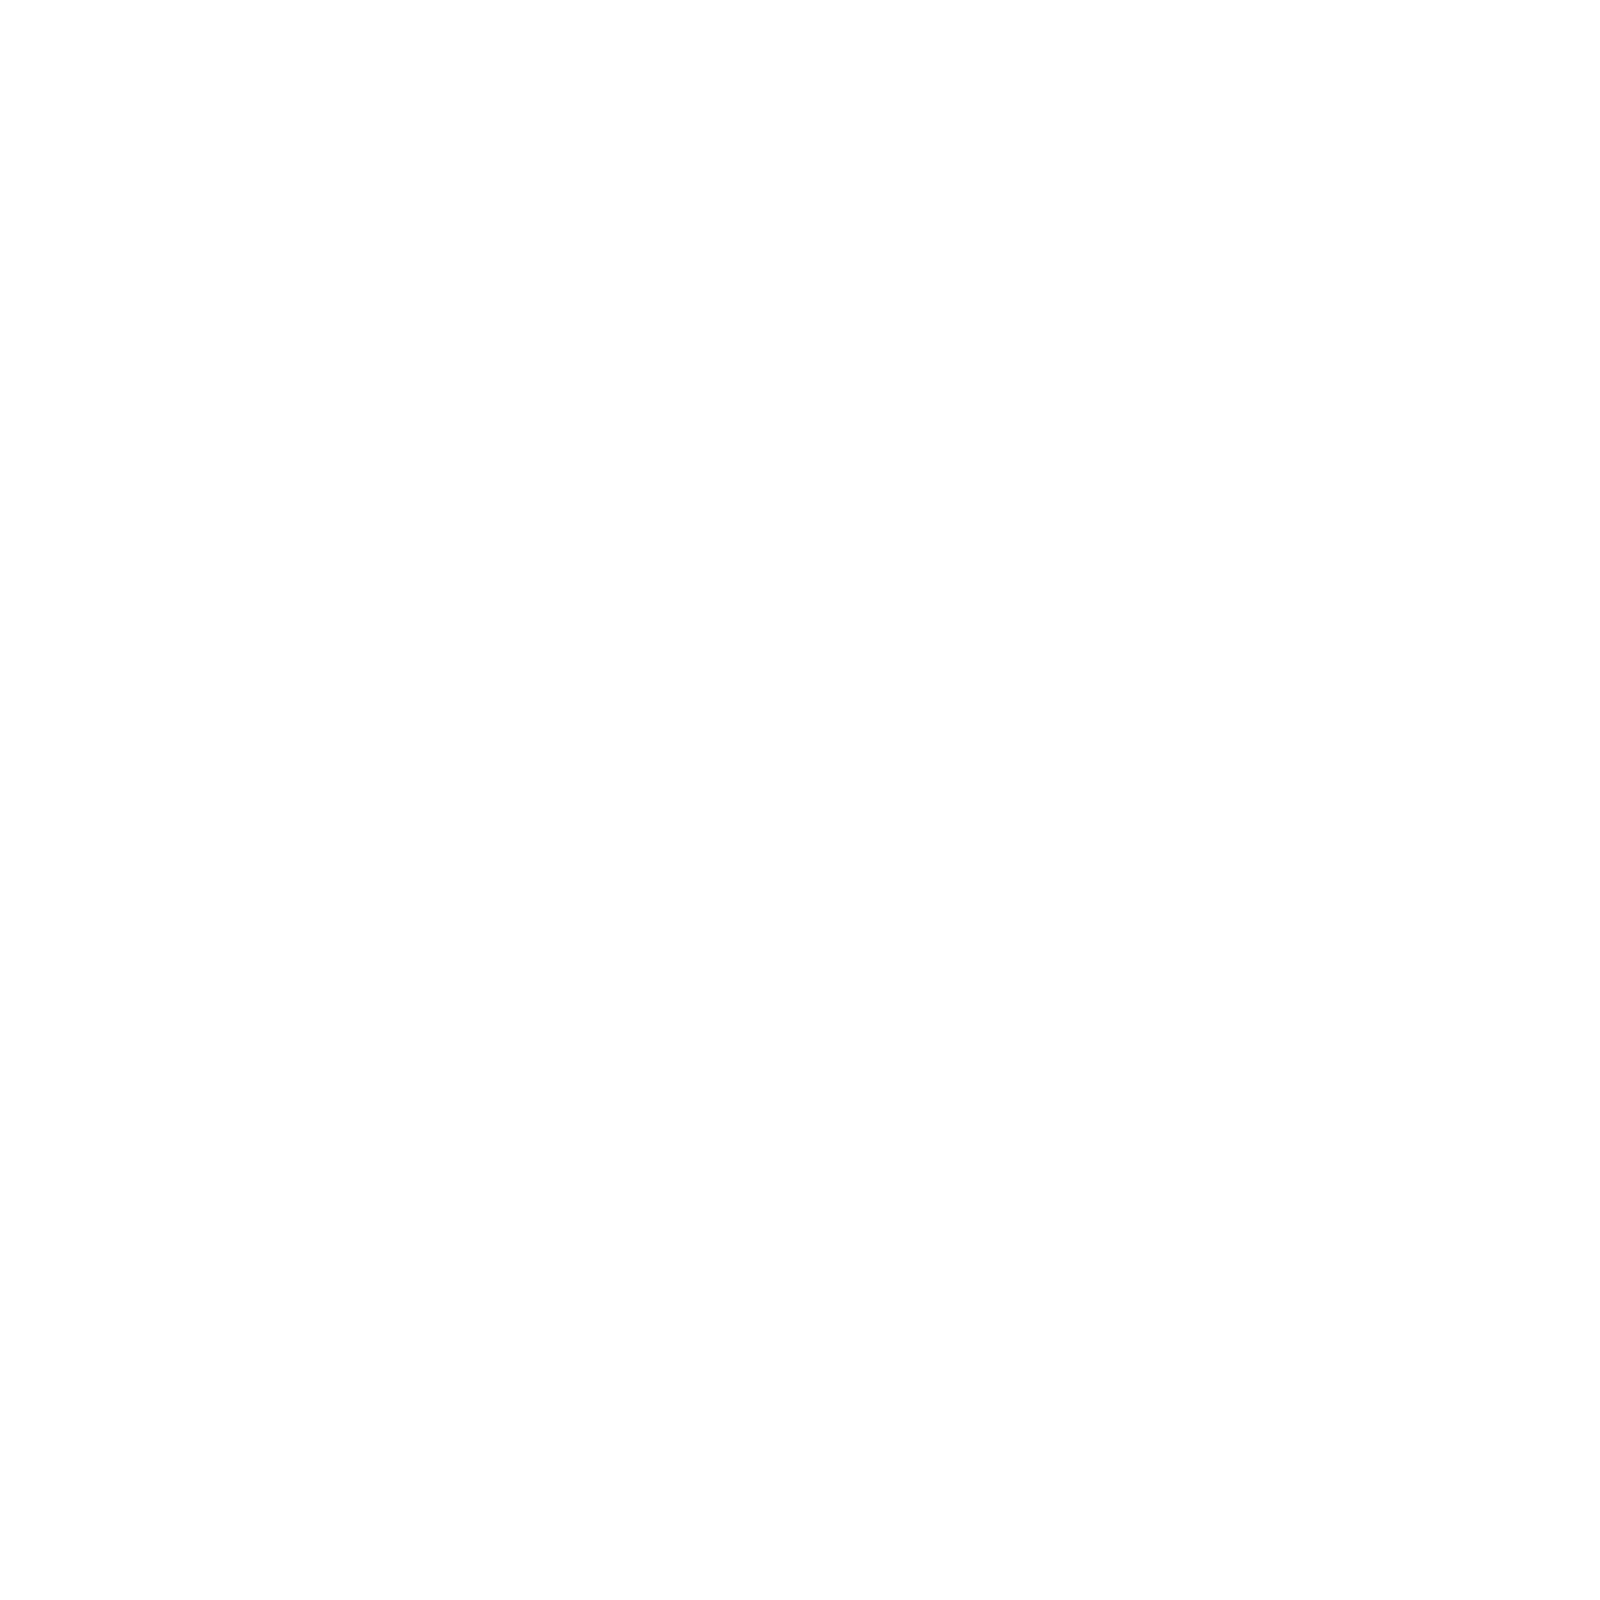

TypeError: 'NoneType' object is not iterable

In [146]:
x, y, degrees = graph_spatial_network_plot_valued(g, graph_edges=False, pbc=False)

In [103]:
class AnimatedNeuralGraph(object):
    def __init__(self, degrees):
        #pass in a graph to create based on graph
        self.fig = plt.figure(figsize=(12, 12))
        self.ax = fig.add_subplot(1, 1, 1)
        self.ani = animation.FuncAnimation(self.fig, self.update_animation, interval=50, frames=100,
                                          init_func=self.init_animation, blit=True)
        self.degrees = degrees
        plt.show()
    def init_animation(self):
        self.nodes = self.ax.scatter(x, y, c=degrees, cmap='viridis', animated=True)
        return self.nodes,

    def update_animation(self, i):
        self.degrees = np.add(self.degrees, np.random.normal(size=len(x)))
        self.nodes.set_array(self.degrees)
        return self.nodes,
    
    def show(self):
        plt.show()
        
a = AnimatedNeuralGraph(degrees)



<IPython.core.display.Javascript object>


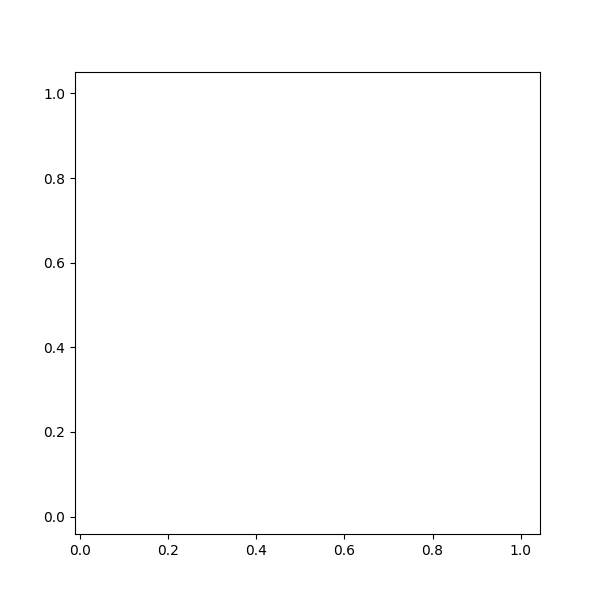

In [147]:
def init_animation():
    nodes = ax.scatter(x, y, c=degrees, cmap='viridis', s=5, animated=True)
    return nodes,

def update_animation(i):
    degrees = np.add(degrees, np.random.normal(size=len(x)))
    nodes.set_array(degrees)
    print('hi')
    return nodes,

#pass in a graph to create based on graph
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)
ani = animation.FuncAnimation(fig, update_animation, init_func=init_animation, frames=100, blit=True)
nodes = ax.scatter(x, y, c=degrees, cmap='viridis', animated=True)


<IPython.core.display.Javascript object>


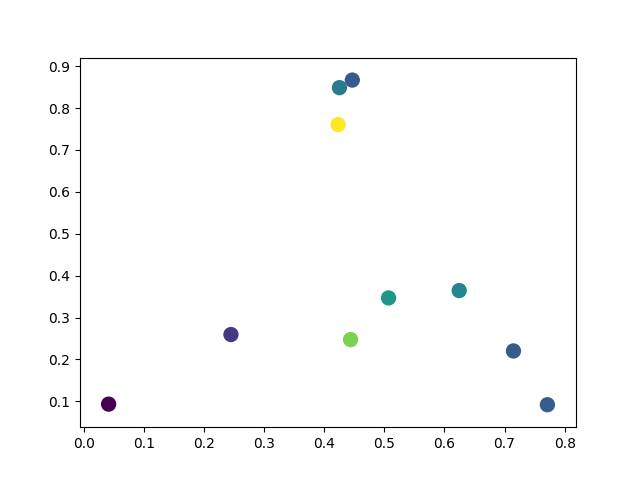

In [148]:
def main():
    numframes = 100
    numpoints = 10
    color_data = np.random.random((numframes, numpoints))
    x, y, c = np.random.random((3, numpoints))

    fig = plt.figure()
    scat = plt.scatter(x, y, c=c, s=100)

    ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes),
                                  fargs=(color_data, scat))
    plt.show()

def update_plot(i, data, scat):
    scat.set_array(data[i])
    print(i)
    return scat,

main()

In [149]:
degrees

array([ 14.10367466,  13.67481439,  12.54716281,   9.49137924,
        12.010807  ,   8.50546845,   5.25592062,   4.91978229,
        13.91254248,   7.62031464,   5.00873854,   7.92209036,
        15.66158242,  10.18070085,  15.3124949 ,  10.73137637,
        12.35944717,  15.82877897,  -0.42423474,   1.54485766,
        14.64047211,  16.17241858,   8.3994047 ,   8.07779184,
         8.36536345,   8.83621925,  13.76447392,   7.99473205,
        15.45525898,   5.50634006,  14.55891071,  15.34325779,
         9.52445946,  12.60349705,  14.00372526,   5.71142671,
         6.651181  ,   8.17864046,   8.43728678,  11.46399666,
         7.52924485,  13.60887556,  12.15882061,   2.09962505,
        11.42868664,   8.20421276,  11.826638  ,  14.30577039,
        10.36694985,  11.15013954])

In [65]:
particles.set_color(['red'])

AttributeError: 'list' object has no attribute 'set_data'

In [41]:
def choose_points(g, coordinate, g_coords=False, ret_coords=False):
    '''
    Find a point near coordinate passed
    '''    
    coordinates = []
    if(g_coords):
        coordinates = g_coords
    else:
        for n in range(g.node_count):
            coordinates.append(g.nodes[n]['coordinate'])
    node = np.square(np.array(coordinates) - np.array(coordinate)).sum(axis=1).argmin()
    if(ret_coords):
        return node, coordinates
    else:
        return node
    
def highlight_by_coordinate(g, coordinates):
    if(type(coordinates[0]) in [int, float]):
        print('single')
        ps = [choose_points(g, coordinates)]
    else:
        ps = []
        g_coords = False
        for c in coordinates:
            p, g_coords = choose_points(g, c, g_coords, ret_coords=True)
            ps.append(p)
    
    print(ps)
    colors = []
    for i in range(g.node_count):
        if(i in ps):
            colors.append('red')
        else:
            colors.append('blue')
    return colors

single
[30]


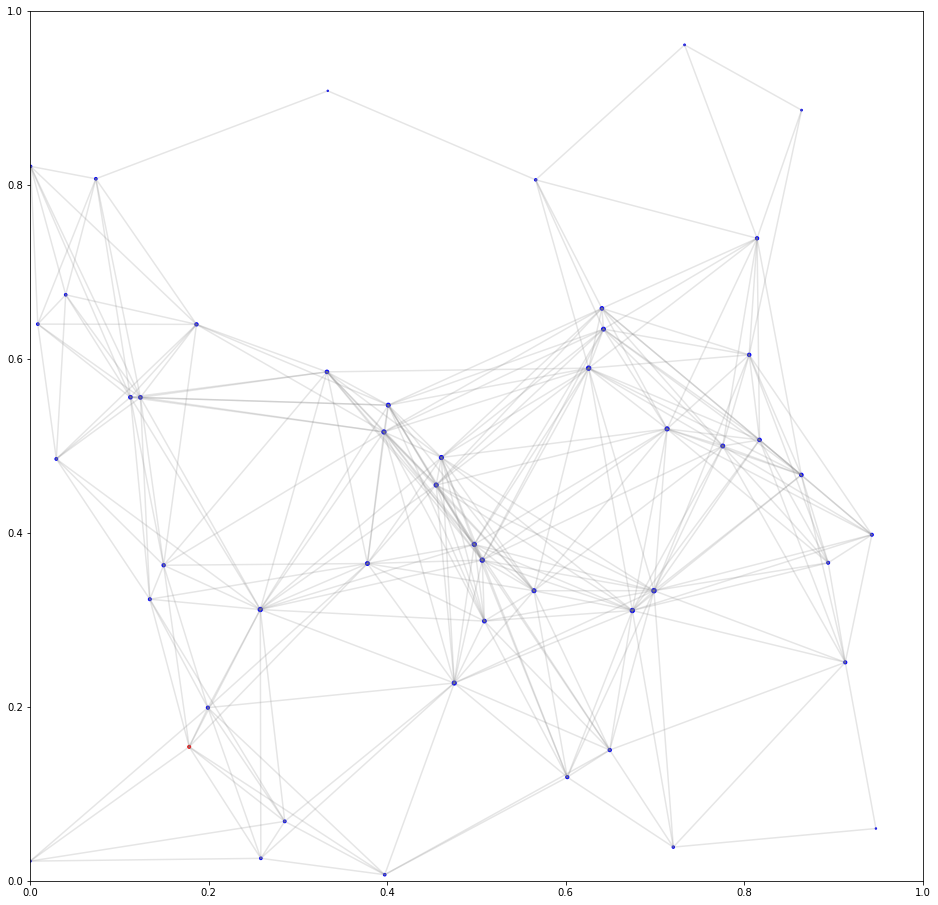

In [46]:
graph_spatial_network_plot_valued(g, color_points=colors, graph_edges=True, pbc=False)

In [96]:
100 * 0.5

50.0

In [108]:
100 * ((1 - (0.5 / 7.466)) ** 10)

49.99825478416441

In [115]:
rate = 1/(1 - math.e ** (math.log(0.5) / 10)) * 0.5

In [116]:
x1 = np.array([0, 10, 20, 30, 40, 50])
y1 = 100 * (0.5 ** (x1 / 10))
x2 = np.linspace(0, 50, 51)
y2 = 100 * ((1 - (0.5 / rate)) ** x2)

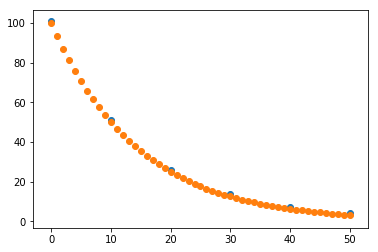

In [119]:
plt.scatter(x1, y1 + 1)
plt.scatter(x2, y2)

In [123]:
granularity=0.1
1/(1 - math.e ** (math.log(g.decay) * granularity)) * g.decay

7.466363086456482

In [128]:
math.log10(1/0.1)

1.0

In [52]:
granularity = 1
(math.e ** -math.log10(granularity)) * granularity

1.0

In [49]:
granularity = 0.3
bg = (math.e ** -math.log10(granularity)) * granularity
non_granular = []
granular = []
for i in range(500):
    #trials
    ng = 0
    g = 0
    for _ in range(50):
        ng += (np.random.uniform() - 0.5) * 2
    for _ in range(int(50 / granularity)):
        g += (np.random.uniform() - 0.5) * 2 * bg
    non_granular.append(ng)
    granular.append(g)


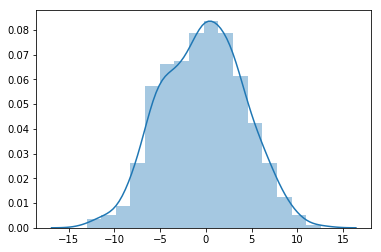

In [50]:
sns.distplot(non_granular)

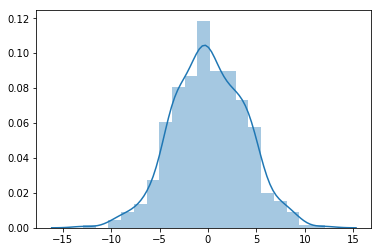

In [51]:
sns.distplot(granular)

In [46]:
(math.e ** -math.log10(granularity)) * granularity

0.03739328092797323